In [5]:
import yaml, os

with open('../../src/parameters/cross-section.yaml', 'r', encoding='utf-8') as f:
    cross_section_baseline = yaml.safe_load(f)['ZpToHG']

# convert pb to fb
cross_section_baseline = {k: v*1e3 for k, v in cross_section_baseline.items()}


cross_section_baseline

{'ZpToHGamma_M600': 47.199999999999996,
 'ZpToHGamma_M700': 37.87,
 'ZpToHGamma_M800': 30.52,
 'ZpToHGamma_M900': 24.68,
 'ZpToHGamma_M1000': 20.11,
 'ZpToHGamma_M1200': 13.5,
 'ZpToHGamma_M1400': 9.228,
 'ZpToHGamma_M1600': 6.37,
 'ZpToHGamma_M1800': 4.422,
 'ZpToHGamma_M2000': 3.093,
 'ZpToHGamma_M2200': 2.16,
 'ZpToHGamma_M2400': 1.51,
 'ZpToHGamma_M2600': 1.057,
 'ZpToHGamma_M3000': 0.5056,
 'ZpToHGamma_M3500': 0.1897}

In [6]:
with open('./rate_limit.yaml', 'r', encoding='utf-8') as f:
    rate_limit = yaml.safe_load(f)

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
import numpy as np

use_helvet = True ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def plot_cross_section_limit(cross_section_limit, x_name: str, SR_choice: str, cuts=None, year='2018', x_min=580, x_max=3480):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run 2"] = np.sum(list(LUMI.values()))
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}

    ## canvas initializing
    # colorlist=['red', 'blue', 'green', 'black', 'cyan', 'darkorange', 'darkviolet', 'SlateGray', 'HotPink', 'LightSkyBlue']
    # mpl.rcParams['axes.prop_cycle'] = cycler(color=colorlist)
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 9))
    ax=plt.gca()
    plt.grid()
    hep.cms.label(data=False, ax=ax, fontsize=18, year=year, lumi=LUMI[year])
    
    ## analyze

        
    ## plot
    # mpl.rcParams['axes.prop_cycle'] = cycler(color=['red', 'blue', 'green', 'darkorange', 'cyan', 'HotPink', 'darkviolet', 'SlateGray', 'black', 'LightSkyBlue'])
    x = [int(k.split('M')[1]) for k in cross_section_limit['Expected Limit'].keys()]
    expected_center = np.array(list(cross_section_limit['Expected Limit'].values()))
    
    ax.scatter(
        x=x, y=np.array(list(cross_section_limit['Observed Limit'].values())), color='black', label='Observed limit (on MC)', marker='o', s=72
    )
    ax.errorbar(
        x=x, y=expected_center,
        yerr=[expected_center-np.array(list(cross_section_limit['Expected -2sigma'].values())), np.array(list(cross_section_limit['Expected +2sigma'].values()))-expected_center],
        label=r'Expected limit $\pm 2\sigma$', linestyle='', linewidth=3, marker='o', markeredgecolor='black', markerfacecolor='white', ecolor='darkorange'
    )
    ax.errorbar(
        x=x, y=expected_center,
        yerr=[expected_center-np.array(list(cross_section_limit['Expected -1sigma'].values())), np.array(list(cross_section_limit['Expected +1sigma'].values()))-expected_center],
        label=r'Expected limit $\pm 1\sigma$', linestyle='', linewidth=3, marker='o', markeredgecolor='black', markerfacecolor='white', ecolor='green'
    )
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too) 

    ## axises
    ax.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(1e-2, ax.get_ylim()[1]*1e1)
    ax.set_yscale('log')
    #ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    #x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    #y_major_locator=MultipleLocator(1)
    #ax.xaxis.set_major_locator(x_major_locator)
    #ax.yaxis.set_major_locator(y_major_locator)
    ax.set_ylabel('95% CL upper limit on '+r'$\sigma[Z^\mathrm{\prime}\to H\gamma]$ (fb)', fontsize=20, ha='right', y=1)

    plt.xticks(size=16)
    plt.yticks(size=16)

    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=22)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    if not os.path.exists(f'../plots/fit/{year}'):
        os.makedirs(f'../plots/fit/{year}')
    plt.savefig(f"../plots/fit/{year}/{SR_choice}_limit.pdf", bbox_inches='tight')
    plt.show()

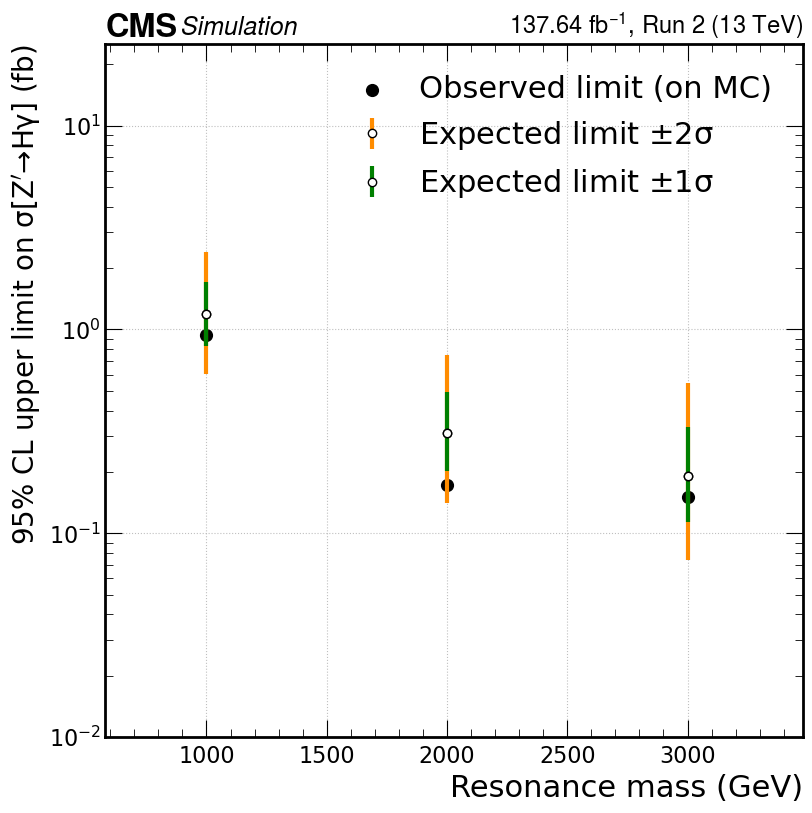

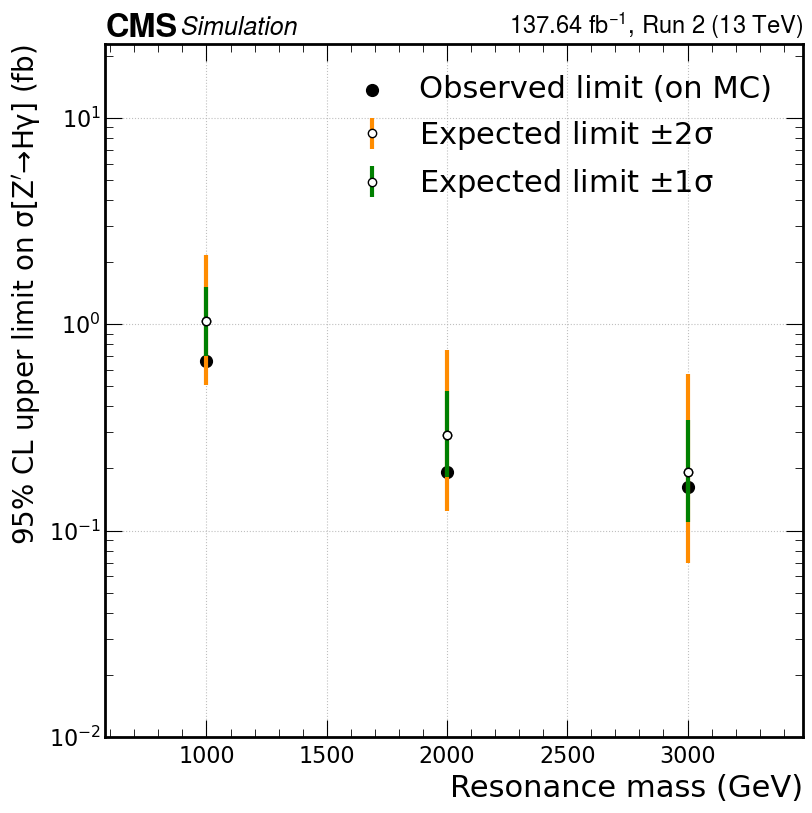

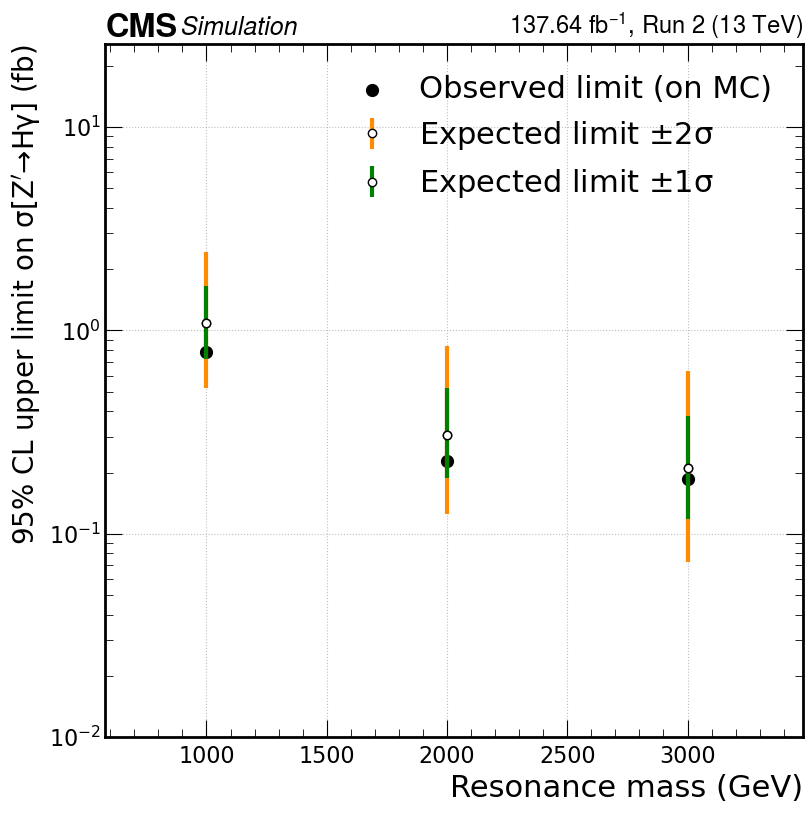

In [8]:
for SR_choice in rate_limit:
    rate_limit[SR_choice]
    cross_section_limit = {
        region: {
            limit: {
                signal: rate_limit[SR_choice][region][limit][signal] * cross_section_baseline[signal] for signal in rate_limit[SR_choice][region][limit]
            } for limit in rate_limit[SR_choice][region]
        } for region in rate_limit[SR_choice]
    }
    cross_section_limit

    plot_cross_section_limit(cross_section_limit=cross_section_limit['SR2'], x_name='Resonance mass (GeV)', year='Run 2', SR_choice=SR_choice)